## PU Learning For News
Initial work

Mainly to start exploring how to vectorize texts and also identify true negatives

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# nltk.download('punkt')
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [5]:
input_file = "./article_dataset.csv"
df_raw = pd.read_csv(input_file, index_col="id")
df_raw = preprocessing.clean_df(df_raw)
df_raw = df_raw[df_raw['cleaned_text'].str.strip() != ""].copy()
df_raw.reset_index(inplace=True)
df_raw['id'] = df_raw.index
df_raw["clean_title"] = df_raw['title'].apply(preprocessing.clean_text)

df = df_raw.copy()
df = preprocessing.turn_into_pu(df, 0.5)

X_train, X_test, y_train, y_test = preprocessing.test_train_split(df)
y_train.index = X_train.index
y_test_true = df_raw.loc[y_test.index, 'label']

X_train['tokens'] = X_train['cleaned_text'].apply(lambda x: x.split())
df.head()

,id,title,author,text,label,cleaned_text,clean_title
0,0,House Dem Aide: We Didn't Even See Comey's Let...,Darrell Lucus,House Dem Aide: We Didn't Even See Comey's Let...,1,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,1,ever get feeling life circle roundabout rather...,flynn hillary clinton big woman campus breitbart
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october tension intellig...,truth might get fired
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,video civilian killed single u airstrike ident...,civilian killed single u airstrike identified
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six year prison ...,iranian woman jailed fictional unpublished sto...


## Vectorizing Text
TF-IDF words

In [6]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=True)
tfidf_matrix = vectorizer.fit_transform(X_train['cleaned_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=X_train.index)

pca = PCA(n_components=6)
principal_components = pca.fit_transform(tfidf_df)
print("Explained Variance: ", pca.explained_variance_ratio_.cumsum())

/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained Variance:  [0.0137519  0.02237517 0.02858603 0.0342658  0.03887197 0.04261636]


### Visualizing Word Vectorization with PCA 

In [7]:
pca_plot = PCA(n_components=2)
principal_components_plot = pca_plot.fit_transform(tfidf_df)

print("Explained Variance: ", pca_plot.explained_variance_ratio_.cumsum())


temp = pd.DataFrame(principal_components_plot, columns=['x', 'y'])
temp['label'] = y_train

# Plot with Plotly Express
fig = px.scatter(temp, x='x', y='y', color='label', title='Scatter Plot with Correlated Colors')
fig.show()

Explained Variance:  [0.0137519  0.02237517]


### Vectorizing through Document Content

In [8]:
analyzer = SentimentIntensityAnalyzer()
def sentiment_maker(df: pd.DataFrame, type:str):
    df['sentiment'] = df[type].apply(analyzer.polarity_scores)
    df = pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)
    df.rename(columns={col: f"{col}_{type}" for col in ["pos", "neu", "neg"]}, inplace=True)
    return df

def count_stop_words(tokens):
    stop_word_count = sum(1 for word in tokens if word in stop_words)
    return stop_word_count / len(tokens)

X_vec = X_train.copy()
X_vec['len'] = X_vec['tokens'].apply(lambda x: len(x))

X_vec = sentiment_maker(X_vec, "cleaned_text")
X_vec = sentiment_maker(X_vec, "clean_title")

X_vec['percent_stop'] = X_vec['tokens'].apply(count_stop_words)
X_vec

,id,title,author,text,cleaned_text,clean_title,tokens,len,neg_cleaned_text,neu_cleaned_text,pos_cleaned_text,compound,neg_clean_title,neu_clean_title,pos_clean_title,compound,percent_stop
13828,13828,A Whale Takes Up Residence in the Hudson River...,Katie Rogers,When Dr. Rachel Dubroff and her family chose t...,dr rachel dubroff family chose apartment river...,whale take residence hudson river new york time,"[dr, rachel, dubroff, family, chose, apartment...",440,0.048,0.848,0.104,0.9776,0.000,1.000,0.000,0.0000,0.004545
8692,8692,"Bill Maher, Faulted for Booking Milo Yiannopou...",Dave Itzkoff,If you were disappointed that Bill Maher broug...,disappointed bill maher brought milo yiannopou...,bill maher faulted booking milo yiannopoulos t...,"[disappointed, bill, maher, brought, milo, yia...",707,0.130,0.750,0.120,-0.7691,0.160,0.667,0.173,0.0516,0.008487
19941,19941,"Polls are tightening, but is the US presidenti...",admin,"Polls are tightening, but is the US presidenti...",poll tightening u presidential election rigged...,poll tightening u presidential election rigged,"[poll, tightening, u, presidential, election, ...",106,0.095,0.707,0.199,0.9084,0.333,0.667,0.000,-0.3612,0.000000
18464,18464,Putin dismisses allegations about Russia's int...,TASS,Putin dismisses allegations about Russia's int...,putin dismisses allegation russia interference...,putin dismisses allegation russia interference...,"[putin, dismisses, allegation, russia, interfe...",116,0.192,0.701,0.107,-0.8505,0.000,1.000,0.000,0.0000,0.000000
11741,11741,Travelers Stranded and Protests Swell Over Tru...,Peter Baker,WASHINGTON — Travelers were stranded around...,washington traveler stranded around world prot...,traveler stranded protest swell trump order ne...,"[washington, traveler, stranded, around, world...",937,0.164,0.697,0.139,-0.9935,0.200,0.800,0.000,-0.2500,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18055,18055,"For Millennials, It's Never Too Early to Save ...",Zach Wichter,You have probably heard it yourself: the impre...,probably heard impression millennials financia...,millennials never early save retirement new yo...,"[probably, heard, impression, millennials, fin...",948,0.060,0.768,0.172,0.9989,0.273,0.727,0.000,-0.3875,0.024262
7538,7538,7 Steps You Should Take To Make Sure Your Expe...,NaN,Email A little planning goes a long way when i...,email little planning go long way come mind ex...,step take make sure experie clickhole,"[email, little, planning, go, long, way, come,...",142,0.177,0.618,0.205,0.6486,0.000,0.685,0.315,0.3182,0.000000
8433,8433,"In a Call to The Times, Trump Blames Democrats...",Maggie Haberman,WASHINGTON — Just moments after the Republi...,washington moment republican plan repeal repla...,call time trump blame democrat failure health ...,"[washington, moment, republican, plan, repeal,...",317,0.115,0.718,0.167,0.9588,0.388,0.612,0.000,-0.6908,0.000000
11739,11739,Press Secretary Affirms that Trump Believes Li...,"Maggie Haberman, Jennifer Steinhauer and Charl...",■ White House press secretary Sean Spicer stoo...,white house press secretary sean spicer stood ...,press secretary affirms trump belief lie milli...,"[white, house, press, secretary, sean, spicer,...",996,0.067,0.786,0.147,0.9976,0.247,0.753,0.000,-0.5574,0.003012


In [10]:
X_vec_numeric = X_vec.select_dtypes(include=np.number).drop(columns=["id"])
principal_components_df = pd.DataFrame(principal_components)
temp_index = X_vec.index
X_vec_numeric.reset_index(inplace=True)
principal_components_df.reset_index(inplace=True)
x_train_combined = pd.concat([X_vec_numeric, principal_components_df], axis=1)
x_train_combined.drop(columns=['index'], inplace=True)
x_train_combined.set_index(temp_index, inplace=True)
x_train_combined.columns = x_train_combined.columns.astype(str)
x_train_combined

,len,neg_cleaned_text,neu_cleaned_text,pos_cleaned_text,compound,neg_clean_title,neu_clean_title,pos_clean_title,compound,percent_stop,0,1,2,3,4,5
13828,440,0.048,0.848,0.104,0.9776,0.000,1.000,0.000,0.0000,0.004545,-0.038253,-0.067442,0.059735,-0.011103,-0.004095,-0.001084
8692,707,0.130,0.750,0.120,-0.7691,0.160,0.667,0.173,0.0516,0.008487,0.128073,-0.088559,0.043477,0.053875,-0.093866,0.091005
19941,106,0.095,0.707,0.199,0.9084,0.333,0.667,0.000,-0.3612,0.000000,0.059731,0.172449,-0.027687,0.078993,0.024848,0.085319
18464,116,0.192,0.701,0.107,-0.8505,0.000,1.000,0.000,0.0000,0.000000,-0.024580,0.033753,-0.142624,-0.095561,0.114686,-0.000531
11741,937,0.164,0.697,0.139,-0.9935,0.200,0.800,0.000,-0.2500,0.000000,0.311791,-0.115377,-0.109717,-0.054600,-0.004922,-0.137425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18055,948,0.060,0.768,0.172,0.9989,0.273,0.727,0.000,-0.3875,0.024262,0.047525,-0.106764,0.053602,-0.003282,-0.125002,0.075461
7538,142,0.177,0.618,0.205,0.6486,0.000,0.685,0.315,0.3182,0.000000,-0.084394,0.002155,0.018893,0.043221,-0.051624,0.064164
8433,317,0.115,0.718,0.167,0.9588,0.388,0.612,0.000,-0.6908,0.000000,0.359120,-0.119433,0.023619,0.106550,-0.035013,-0.027166
11739,996,0.067,0.786,0.147,0.9976,0.247,0.753,0.000,-0.5574,0.003012,0.533998,-0.116642,0.032358,0.031103,0.048590,-0.079587


### Trying Logistic

In [11]:
### Preprocessing X test
## Same preprocessing X train went through
## Utilizing fitted pca and tfidf
test_tfidf_matrix = vectorizer.transform(X_test['cleaned_text'])

test_tfidf = pd.DataFrame(test_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=X_test.index)
test_pca = pd.DataFrame(pca.transform(test_tfidf))


X_test_vec = X_test.copy()
X_test_vec['tokens'] = X_test_vec['cleaned_text'].apply(lambda x: x.split())
X_test_vec['len'] = X_test_vec['tokens'].apply(lambda x: len(x))
X_test_vec = sentiment_maker(X_test_vec, "cleaned_text")
X_test_vec = sentiment_maker(X_test_vec, "clean_title")
X_test_vec['percent_stop'] = X_test_vec['tokens'].apply(count_stop_words)

X_vec_numeric = X_test_vec.select_dtypes(include=np.number).drop(columns=["id"])
x_test_index = X_test.index
X_vec_numeric.reset_index(inplace=True)
test_pca.reset_index(inplace=True)
x_test_processed = pd.concat([X_vec_numeric, test_pca], axis=1)
x_test_processed.set_index(x_test_index, inplace=True)
x_test_processed.columns = x_test_processed.columns.astype(str)
x_test_processed.drop(columns=['index'], inplace=True)

### Hyper-parmeter tuning

In [18]:
logit = LogisticRegression()
from sklearn.model_selection import GridSearchCV

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [1000,2500, 5000]
    }
]

clf = GridSearchCV(logit, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(x_train_combined,y_train)

Fitting 3 folds for each of 660 candidates, totalling 1980 fits


/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/izimmer/

### Creating Logistic Regression Model
Model trained on PU data\
Confusion Matrix based on true values of y

/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



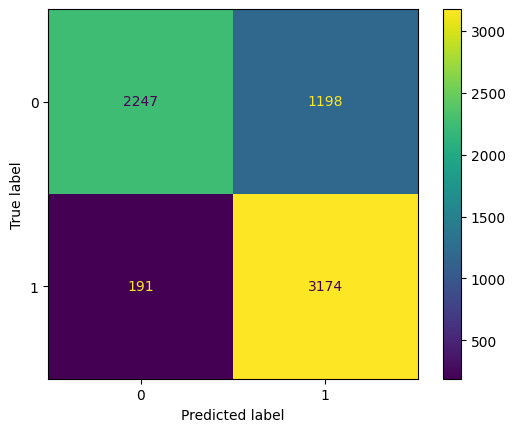

In [23]:
## Making Model
logreg = LogisticRegression(random_state=97)
logreg.fit(x_train_combined, y_train)

y_pred_proba = logreg.predict_proba(x_test_processed)
y_pred = [1 if proba[1] > 0.75 else 0 for proba in y_pred_proba]
confusion_matrix = metrics.confusion_matrix(y_test_true, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [24]:
percentages = np.arange(0, 1, 0.05)
accuracy = []
for cutoff in percentages:
    y_pred = [1 if proba[1] > cutoff else 0 for proba in y_pred_proba]
    accurate = sum(y_pred == y_test_true) / len(y_test_true)
    accuracy.append(accurate)
    
data = {
    'Cutoff': percentages,
    'Accuracy': accuracy
}

accutacy_table = pd.DataFrame(data)

# Create a line plot
fig = px.line(accutacy_table, x='Cutoff', y='Accuracy', title='Accuracy vs Cutoff',
              labels={'Cutoff': 'Threshold Cutoff', 'Accuracy': 'Accuracy'})
fig.show()

Cuttoff with best accuracy matches ratio of negative to postiive data ratio on the original dataset